In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

sns.color_palette("husl")
sns.set_style('darkgrid')

# Data    
# Four years' (209 weeks) records of sales, media impression and media spending at weekly level.   
df = pd.read_csv('data.csv')
df

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,2018,2,5,5,22,13038,13828188,387,2135131,...,0,0,0,0,0,0,0,0,0,0
205,2018-07-08,2018,2,6,1,23,0,3714294,0,1448480,...,0,0,0,0,0,0,0,0,0,0
206,2018-07-15,2018,2,6,2,24,2225092,5102353,0,1307764,...,0,0,0,0,0,0,0,0,0,0
207,2018-07-22,2018,2,6,3,25,17544331,1478566,1891,510539,...,0,0,0,0,0,0,0,0,0,0


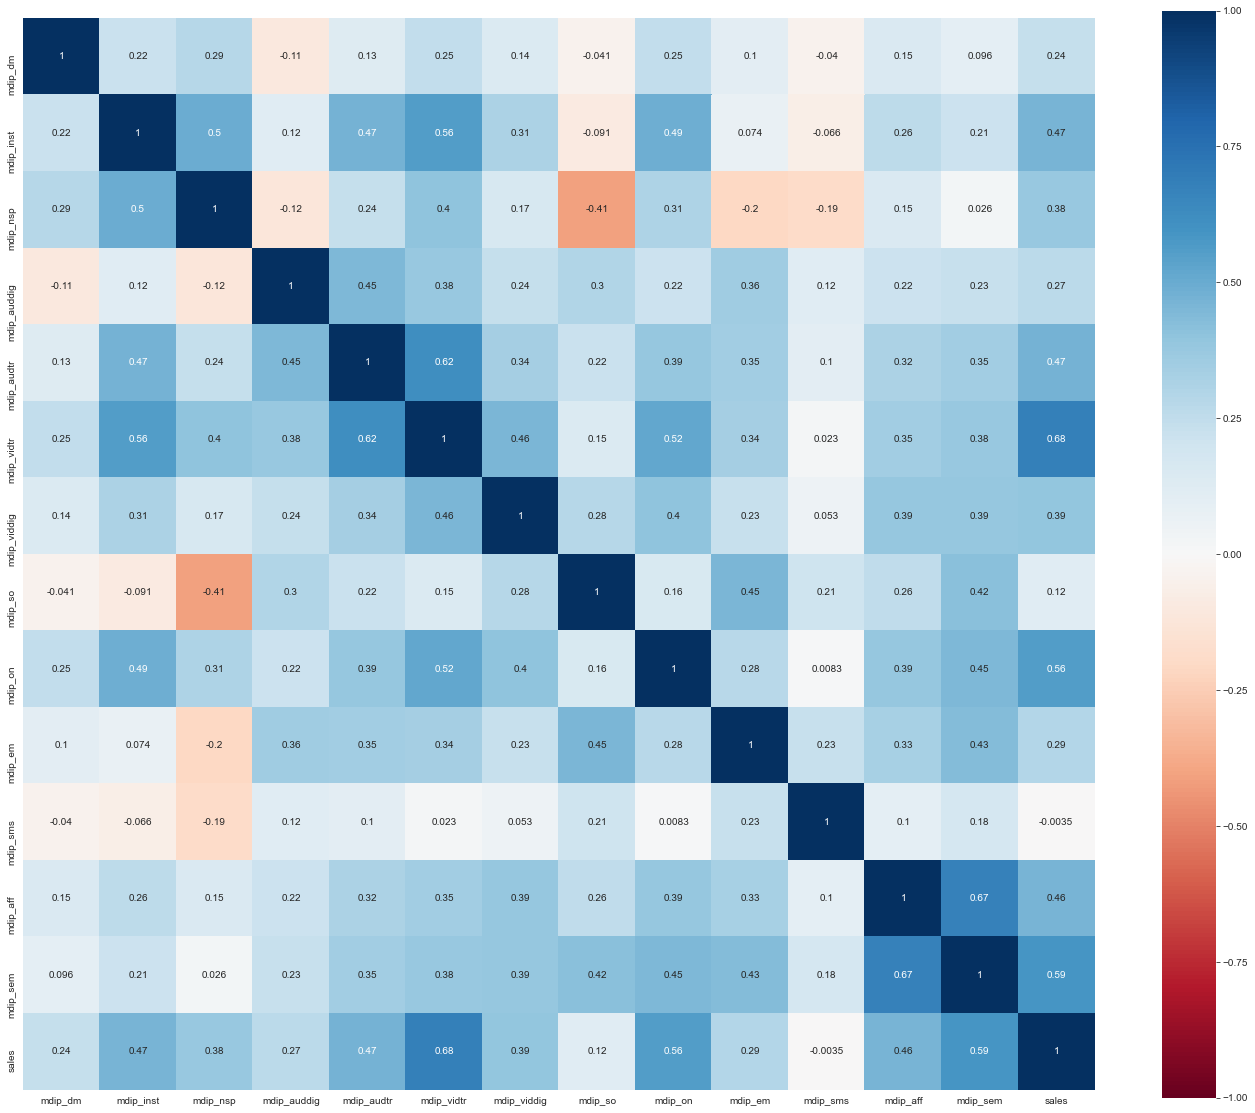

<Figure size 3600x3600 with 0 Axes>

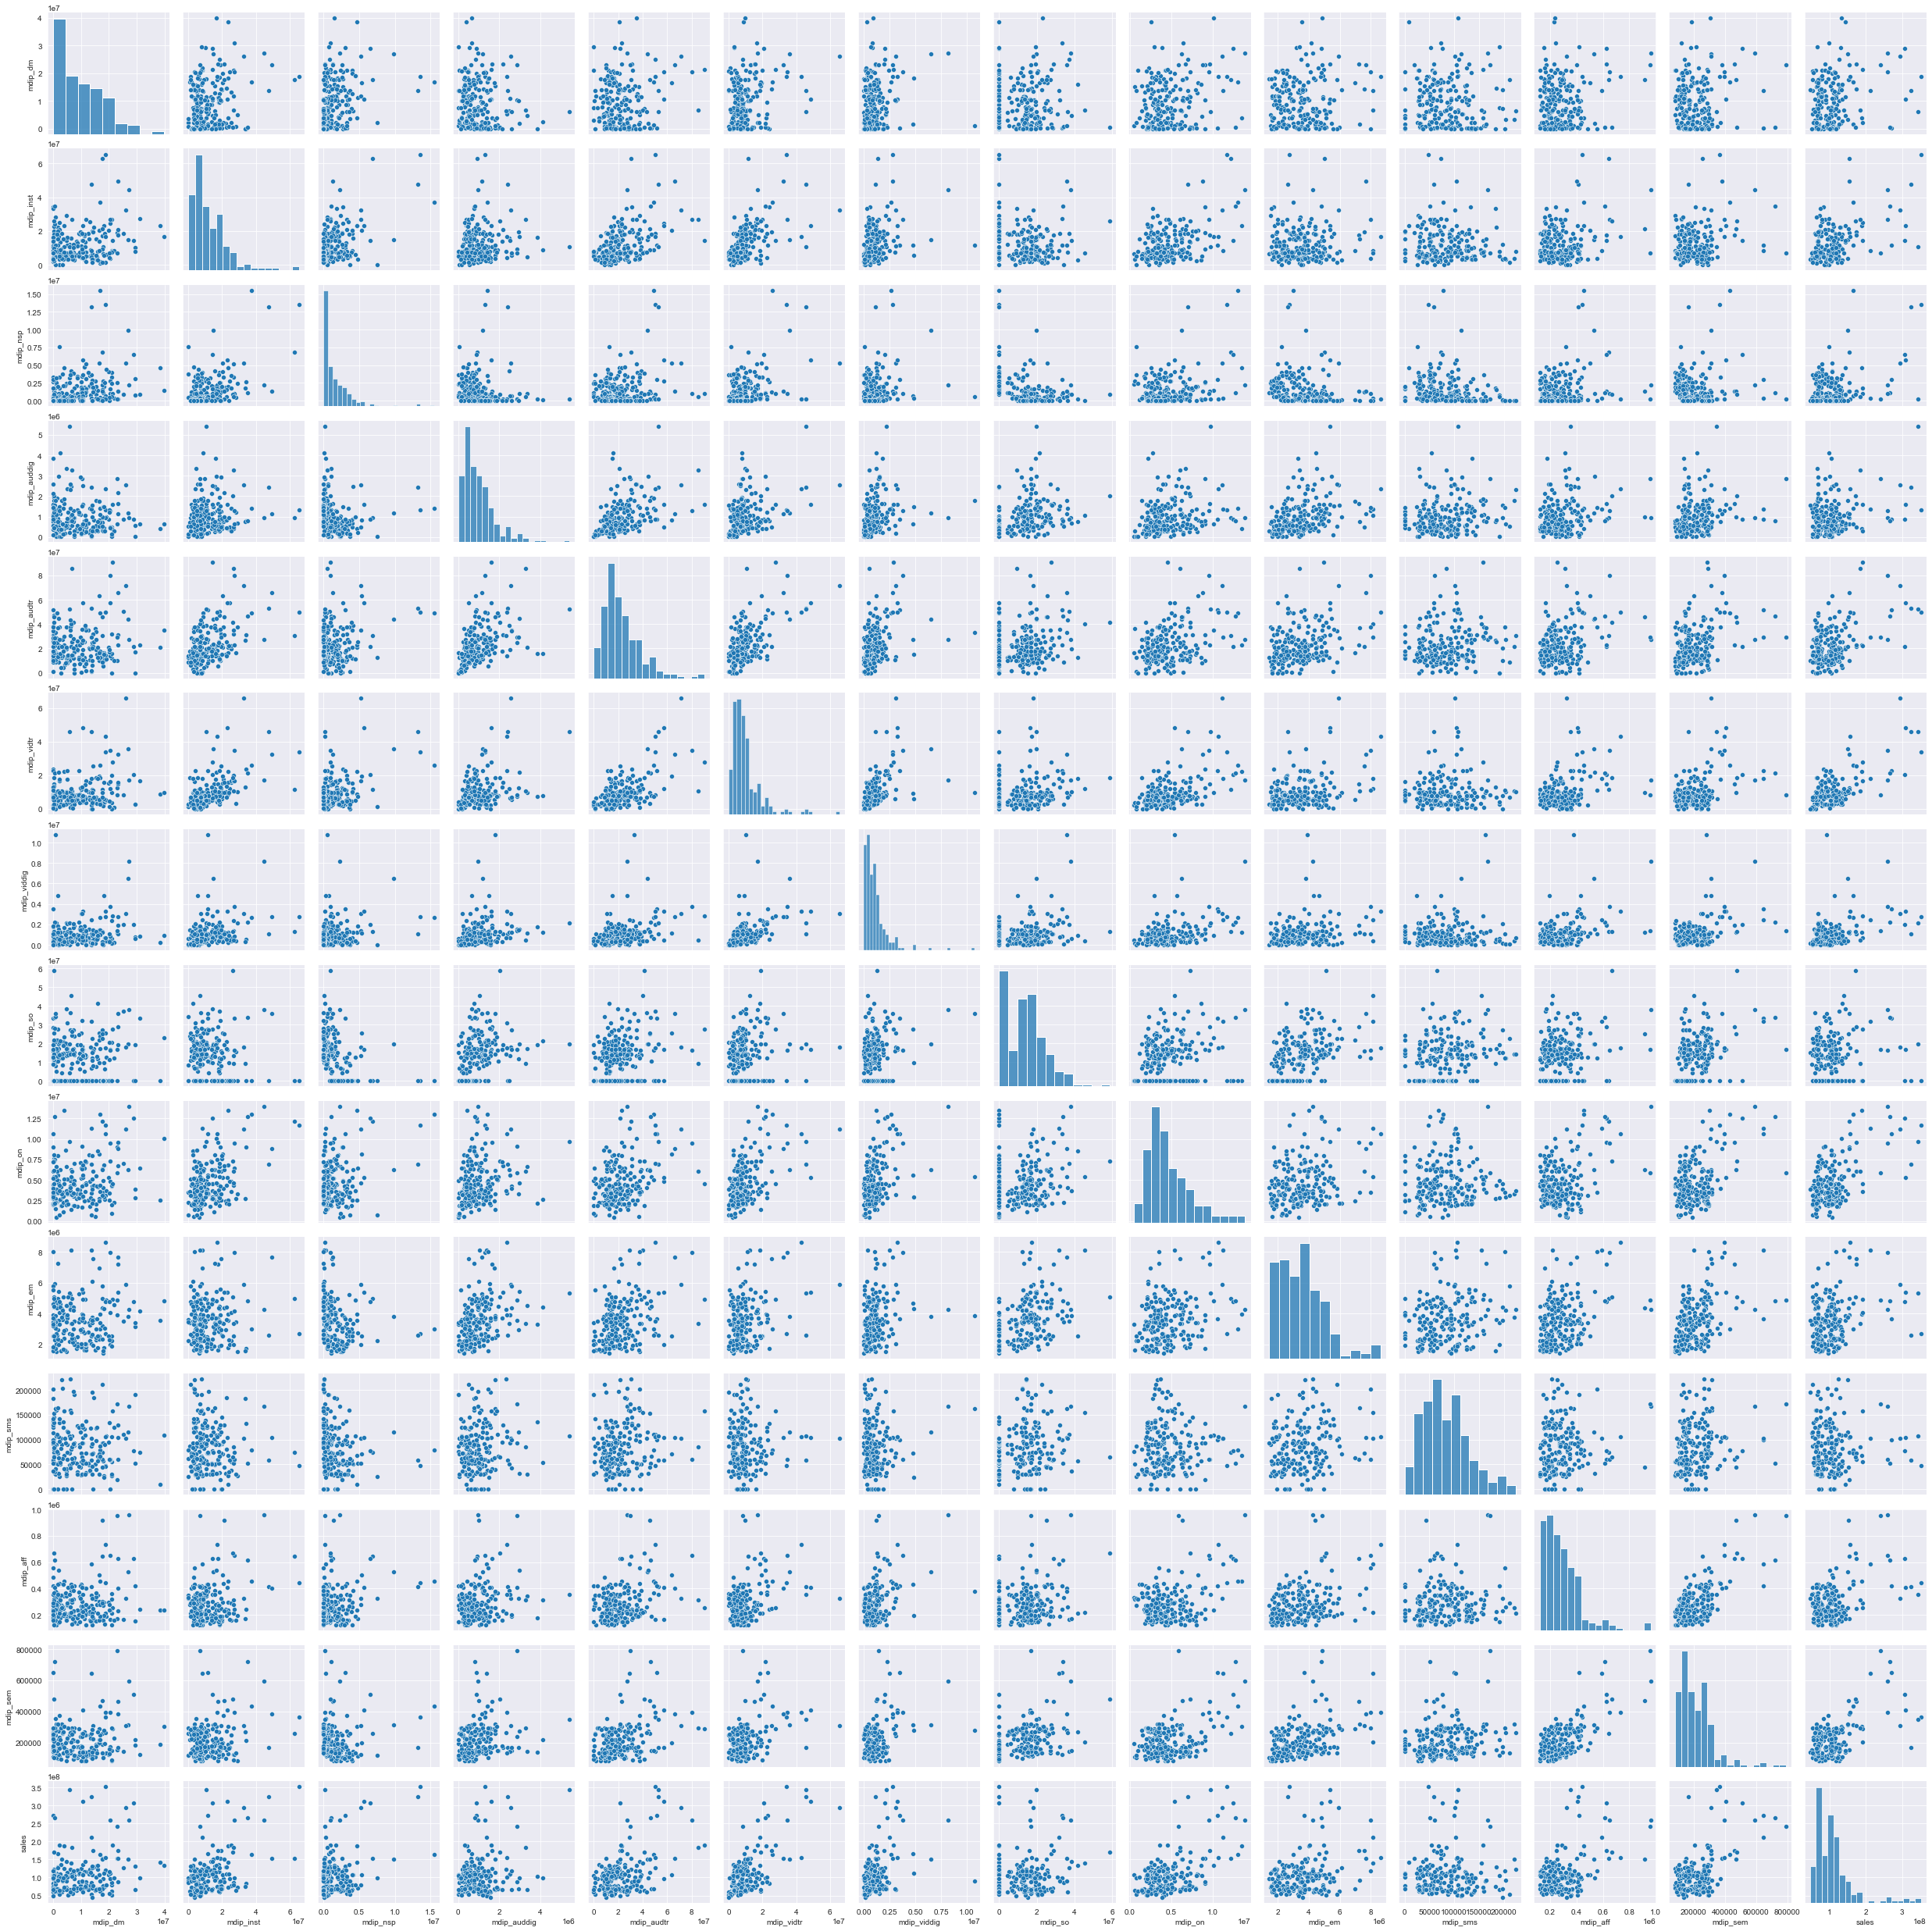

In [19]:
#1. media variables
# media impression
mdip_cols=[col for col in df.columns if 'mdip_' in col]
# media spending
mdsp_cols=[col for col in df.columns if 'mdsp_' in col]

# 2. control variables
# macro economics variables
me_cols = [col for col in df.columns if 'me_' in col]
# store count variables
st_cols = ['st_ct']
# markdown/discount variables
mrkdn_cols = [col for col in df.columns if 'mrkdn_' in col]
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]
base_vars = me_cols+st_cols+mrkdn_cols+hldy_cols+seas_cols

# 3. sales variables
sales_cols =['sales']

df[['wk_strt_dt']+mdip_cols+['sales']].head()

# EDA - correlation, distribution plots
plt.figure(figsize=(24,20))
sns.heatmap(df[mdip_cols+['sales']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

plt.figure(figsize=(50,50))
sns.pairplot(df[mdip_cols+['sales']], vars=mdip_cols+['sales'])


Text(0.5, 1.0, 'Hill Function')

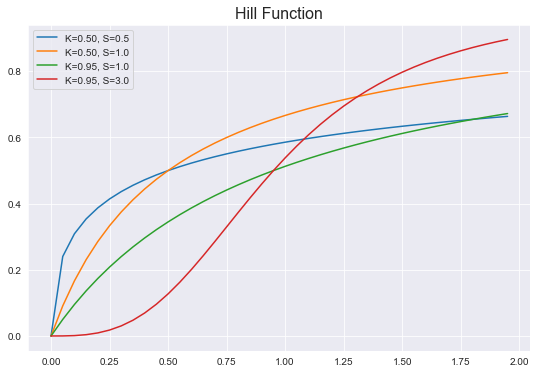

In [21]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df


# plot adstock with varying decay
# fig, ax = plt.subplots(figsize=(15,5))
# psets = [
#     [8, 1, 0.1],
#     [8, 1, 0.9]
# ]
# xm = df['mdip_vidtr'].values
# sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
# for i in range(len(psets)):
#     p = psets[i]
#     L, P, D = p[0], p[1], p[2]
#     xm_adstocked = apply_adstock(xm, L, P, D)
#     sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
#                  label='L=%d, P=%d, D=%.1f'%(L, P, D))
#     ax.lines[i+1].set_linestyle("--")
# ax.set_title('Adstock Parameter: Decay', fontsize=16)

# # plot adstock with varying length
# fig, ax = plt.subplots(figsize=(15,5))
# psets = [
#     [4, 1, 0.9],
#     [12, 1, 0.9]
# ]
# xm = df['mdip_vidtr'].values
# sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
# for i in range(len(psets)):
#     p = psets[i]
#     L, P, D = p[0], p[1], p[2]
#     xm_adstocked = apply_adstock(xm, L, P, D)
#     sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
#                  label='L=%d, P=%d, D=%.1f'%(L, P, D))
#     ax.lines[i+1].set_linestyle("--")
# ax.set_title('Adstock Parameter: Length', fontsize=16)


# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

# # plot hill function with varying K and S
# fig, ax = plt.subplots(figsize=(9,6))
# psets = [
#     [0.5, 0.5],
#     [0.5, 1.0],
#     [0.95, 1.0],
#     [0.95, 3.0]
# ]
# xm = np.arange(0,2,0.05)
# for i in range(len(psets)):
#     p = psets[i]
#     ec, slope = p[0], p[1]
#     sns.lineplot(x=xm, y=hill_transform(xm, ec, slope), ax=ax, 
#                  label='K=%.2f, S=%.1f'%(ec, slope))
#     #ax.lines[i+1].set_linestyle("--")
# ax.set_title('Hill Function', fontsize=16)



In [22]:
# 2.1 Control Model / Base Sales Model
import pystan
import os
os.environ['CC'] = 'gcc-10'
os.environ['CXX'] = 'g++-10'

# helper functions
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data


In [23]:
# mean-centralize: sales, numeric base_vars
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]
X1 = df_ctrl[pos_vars].values

# variables may have either positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}
parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}
model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''

sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4,control=dict(adapt_delta=0.95))
fit1_result = fit1.extract()



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a396b59aabedfaa132f3a814776a219f NOW.
INFO:pystan:OS: win32, Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21


Compiling C:\Users\pscheetz\AppData\Local\Temp\tmpusb9kvbi\stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_6426481761465342365.pyx because it changed.
[1/1] Cythonizing C:\Users\pscheetz\AppData\Local\Temp\tmpusb9kvbi\stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_6426481761465342365.pyx
building 'stanfit4anon_model_a396b59aabedfaa132f3a814776a219f_6426481761465342365' extension
C:\Users\pscheetz\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\pscheetz\AppData\Local\Temp\tmpusb9kvbi -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\src -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.66.0 -IC:\Users\pscheetz\Anaconda3\

In [ ]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

In [24]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred


In [26]:
base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values



mape:  26.099983563003637


In [30]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] = pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect = Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] = log1p(cum_effect/mu_mdip[media]);
    }
  X = append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''


13

In [31]:
sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=500, chains=2)
fit2_result = fit2.extract()


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6677ffefdee0513f144508ee1783d0c NOW.
INFO:pystan:OS: win32, Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21


Compiling C:\Users\pscheetz\AppData\Local\Temp\tmp6fqkdyhy\stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_3074347253218479479.pyx because it changed.
[1/1] Cythonizing C:\Users\pscheetz\AppData\Local\Temp\tmp6fqkdyhy\stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_3074347253218479479.pyx
building 'stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_3074347253218479479' extension
C:\Users\pscheetz\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\pscheetz\AppData\Local\Temp\tmp6fqkdyhy -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\src -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.66.0 -IC:\Users\pscheetz\Anaconda3\

In [33]:
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'])

{'max_lag': 8,
 'media_vars': ['mdip_dm',
  'mdip_inst',
  'mdip_nsp',
  'mdip_auddig',
  'mdip_audtr',
  'mdip_vidtr',
  'mdip_viddig',
  'mdip_so',
  'mdip_on',
  'mdip_em',
  'mdip_sms',
  'mdip_aff',
  'mdip_sem'],
 'ctrl_vars': ['base_sales'],
 'decay': [0.5331286942219963,
  0.4937107132735008,
  0.5016239438632376,
  0.49566445216772403,
  0.4950929122036547,
  0.47619558416723323,
  0.5092671158212397,
  0.507854341750036,
  0.5050394515824286,
  0.5049931491924642,
  0.520915681635542,
  0.5042056374585274,
  0.46349182045729204],
 'peak': [1.2437457303580643,
  1.507023318550295,
  1.9307174814240307,
  1.857510665601326,
  1.863780128382362,
  1.4069057250749566,
  1.7110972615109574,
  1.8925217094833557,
  1.6576300620739157,
  1.8097660858442872,
  2.5409541454507627,
  1.7464602878655513,
  0.9467806407795686],
 'beta': [0.07550212188564644,
  0.03133236110277461,
  0.03237610794095634,
  0.017367628833112648,
  0.014979359756954223,
  0.03183899087952723,
  0.0207909966

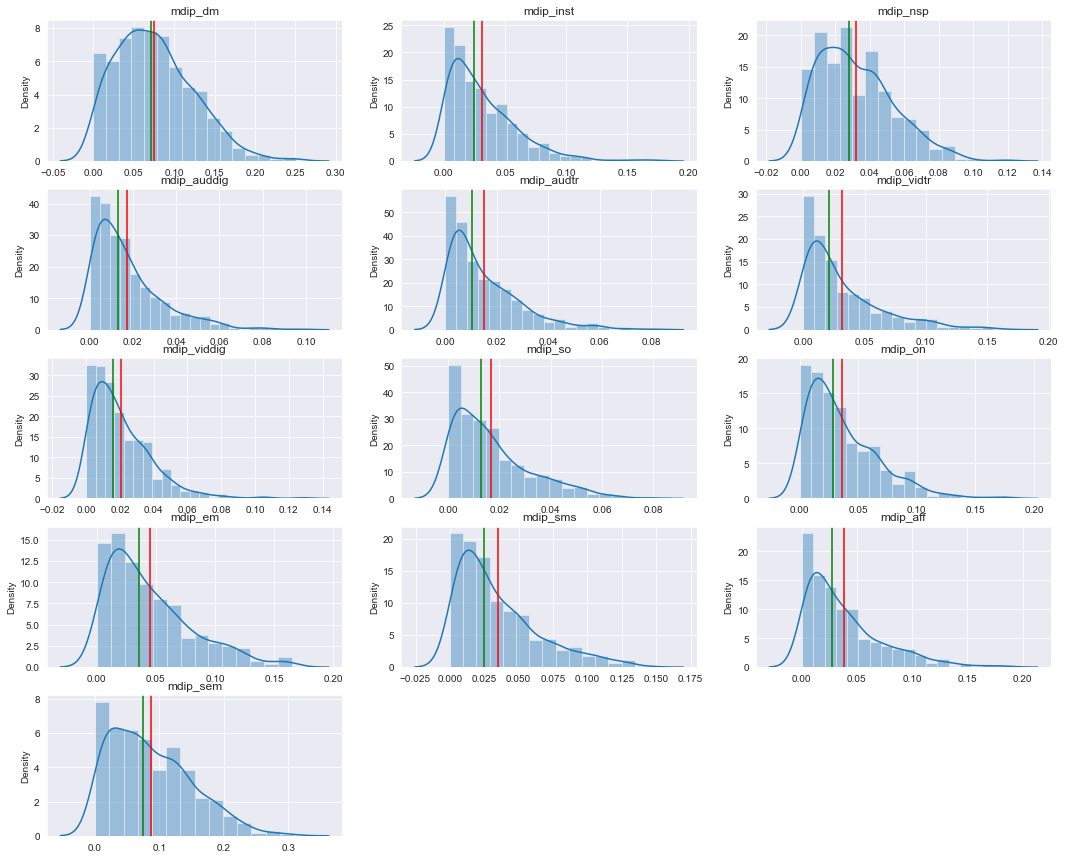

In [34]:
# plot media coefficients' distributions
# red line: mean, green line: median
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)


In [12]:
# Decompose sales to media channels' contribution
# Each media channel's contribution = total sales - sales upon removal the channel    

# decompose sales to media contribution
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2


In [103]:
mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)
mc_df
# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')


rmse (log-log model):  0.13643527815503523
mape (multiplicative model):  20.242477127984497


,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,mdip_vidtr,mdip_viddig,mdip_so,mdip_on,mdip_em,mdip_sms,mdip_aff,mdip_sem,baseline,y_true2,mc_pred,mc_true,mc_delta,sales
0,2.364079e+06,2.346613e+06,6.287702e+05,1.851992e+05,3.661342e+05,1.286682e+06,9.037867e+05,0.000000e+00,6.555295e+05,3.516422e+05,2.894072e+04,5.524808e+05,3.012338e+06,5.936926e+07,1.666808,0.056883,0.293385,-0.236502,7.205146e+07
1,3.806724e+06,2.322625e+06,1.358905e+06,3.681599e+05,6.412931e+05,1.516841e+06,1.154687e+06,0.000000e+00,1.052072e+06,7.176507e+05,1.276817e+05,9.018151e+05,2.403211e+06,6.242311e+07,1.729215,0.260489,0.359289,-0.098801,7.879477e+07
2,3.024834e+06,1.283579e+06,1.352166e+06,3.380320e+05,4.792990e+05,9.905426e+05,7.408729e+05,0.000000e+00,9.160910e+05,7.419310e+05,2.543743e+05,7.283016e+05,1.328779e+06,5.789238e+07,1.648481,0.410534,0.286516,0.124018,7.007119e+07
3,2.532947e+06,1.029009e+06,1.396974e+06,3.525965e+05,3.180663e+05,8.360526e+05,5.883323e+05,0.000000e+00,9.862632e+05,7.955320e+05,4.126000e+05,6.844517e+05,1.327063e+06,5.738258e+07,1.635259,0.435019,0.268243,0.166777,6.864246e+07
4,3.175974e+06,1.776652e+06,1.933017e+06,6.437952e+05,3.633578e+05,1.373751e+06,1.113710e+06,0.000000e+00,1.713910e+06,1.210977e+06,8.553518e+05,1.066985e+06,2.304249e+06,6.865905e+07,1.797662,0.487095,0.365655,0.121439,8.619078e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,6.934254e+05,3.634492e+05,1.633209e+02,4.192757e+05,2.674217e+05,4.143620e+05,1.646018e+05,4.333175e+05,9.059299e+05,9.633791e+05,7.894004e+05,4.278433e+05,1.627627e+06,5.924719e+07,1.617443,0.424252,0.181102,0.243151,6.671739e+07
205,2.303238e+06,2.385128e+06,3.528886e+02,2.331101e+06,1.248408e+06,3.096077e+06,8.465500e+05,2.279742e+06,4.688024e+06,4.661560e+06,3.576235e+06,2.562666e+06,9.003466e+06,7.844743e+07,2.086769,0.541576,0.692732,-0.151156,1.174300e+08
206,2.870584e+05,7.129673e+05,1.670834e+02,7.854381e+05,4.776497e+05,1.096573e+06,3.976652e+05,6.301442e+05,1.281489e+06,1.753211e+06,1.174562e+06,1.187863e+06,2.851967e+06,5.140185e+07,1.592652,0.437456,0.314279,0.123177,6.403861e+07
207,7.506245e+05,3.029716e+05,8.581953e+01,4.490112e+05,3.491828e+05,6.332748e+05,2.916467e+05,3.431822e+05,6.405907e+05,1.249150e+06,9.506816e+05,8.694162e+05,1.488849e+06,4.525098e+07,1.495766,0.436319,0.232273,0.204046,5.356965e+07


In [36]:
# 2.3 Diminishing Return Model    
def create_hill_model_data(df, mc_df, adstock_params, media):
    y = mc_df['mdip_'+media].values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
    x = df['mdsp_'+media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y
        
    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    return model_data, sc

model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}
transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = beta_hill * Hill(X[i], ec, slope);
  }
}
model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''


In [38]:

# pipeline for training one hill model for a media channel
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object    
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sampling(data=data, iter=2000, chains=4)
    fit_result = fit.extract()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']), 
            'ec': np.mean(hill_model['ec_list']), 
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']), 
            'ec': np.median(hill_model['ec_list']), 
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

def evaluate_hill_model(hill_model, hill_model_params):
    x = hill_model['data']['X']
    y_true = hill_model['data']['y'] * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ', 
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred



In [39]:
# train hill models for all media channels
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}
to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
for media in to_train:
    print('training for media: ', media)
    hill_model = train_hill_model(df, mc_df, adstock_params, media, sm3)
    hill_models[media] = hill_model



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3cb749fc265a04310753b249f454cb47 NOW.
INFO:pystan:OS: win32, Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21


Compiling C:\Users\pscheetz\AppData\Local\Temp\tmpjvt0d41v\stanfit4anon_model_3cb749fc265a04310753b249f454cb47_2308069863390467995.pyx because it changed.
[1/1] Cythonizing C:\Users\pscheetz\AppData\Local\Temp\tmpjvt0d41v\stanfit4anon_model_3cb749fc265a04310753b249f454cb47_2308069863390467995.pyx
building 'stanfit4anon_model_3cb749fc265a04310753b249f454cb47_2308069863390467995' extension
C:\Users\pscheetz\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\pscheetz\AppData\Local\Temp\tmpjvt0d41v -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\src -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\pscheetz\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.66.0 -IC:\Users\pscheetz\Anaconda3\

training for media:  on
training for media:  sem


In [40]:
# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')


In [92]:
# evaluate model params extracted by mean
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_mean[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)
# evaluate model params extracted by median
# for md in list(hill_models.keys()):
#     print('evaluating media: ', md)
#     hill_model = hill_models[md]
#     hill_model_params = hill_model_params_med[md]
#     _ = evaluate_hill_model(hill_model, hill_model_params)



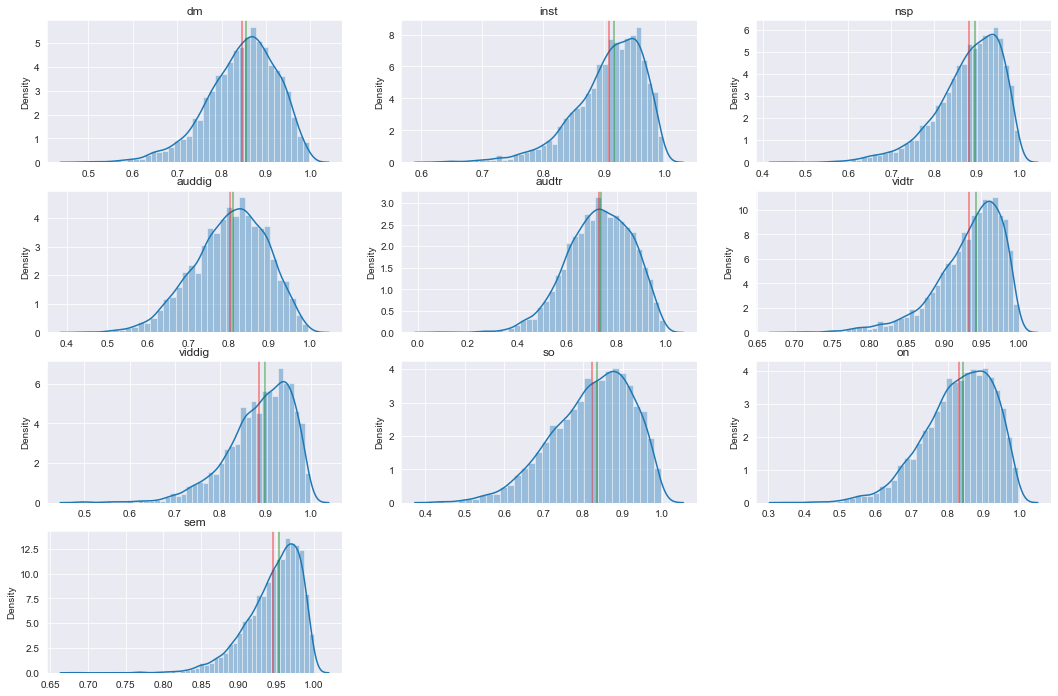

In [42]:
# plot ec distribution
f = plt.figure(figsize=(18,12))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    x = hill_models[md]['ec_list']
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set_title(md)



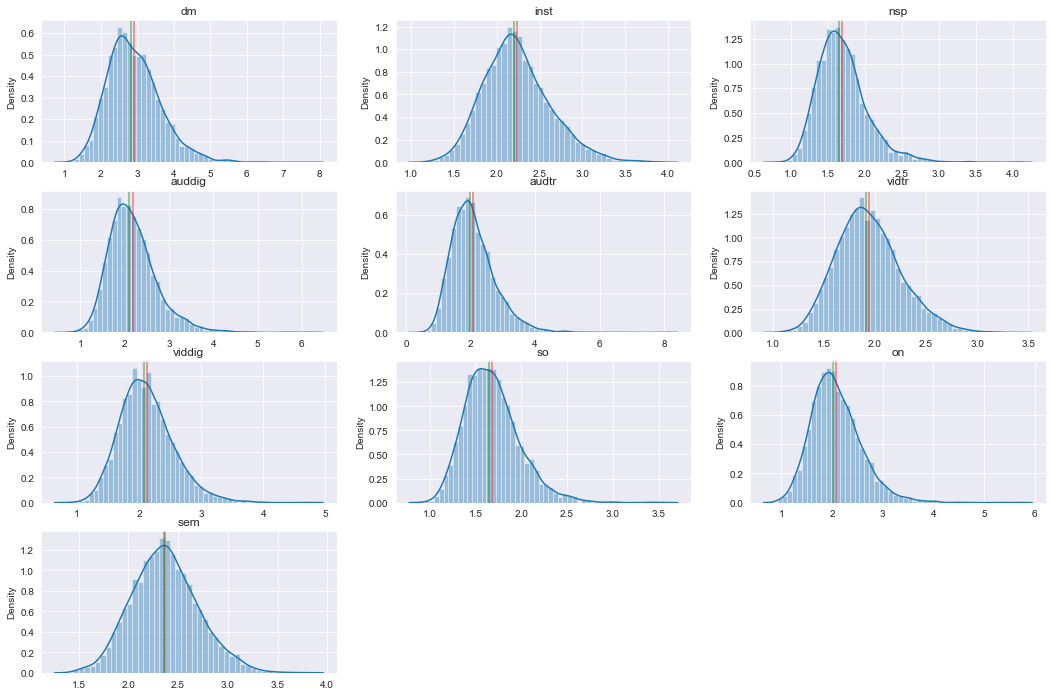

In [43]:

# plot slope distribution
f = plt.figure(figsize=(18,12))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    x = hill_models[md]['slope_list']
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set_title(md)

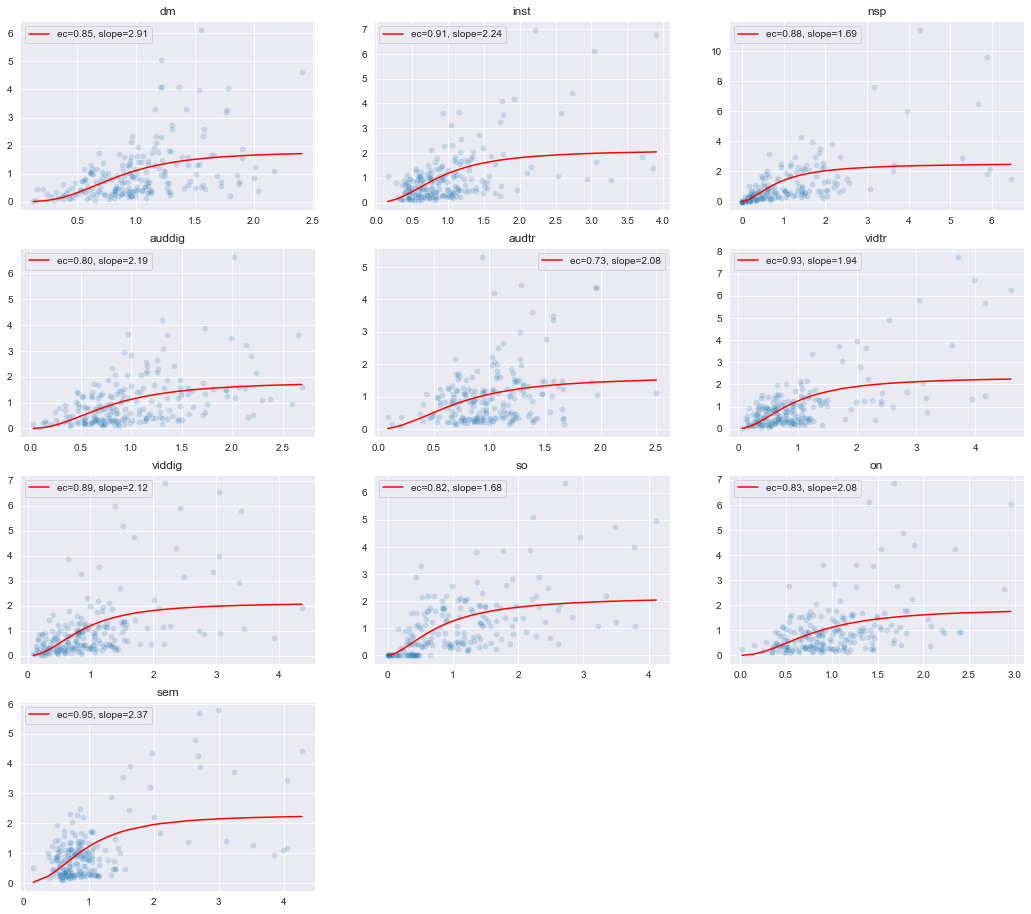

In [44]:

# plot fitted hill function
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r', 
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)




In [102]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df['mdsp_'+md] = x
# ms_df.to_csv('ms_df1.csv', index=False)
ms_df

,mdsp_dm,mdsp_inst,mdsp_nsp,mdsp_auddig,mdsp_audtr,mdsp_vidtr,mdsp_viddig,mdsp_so,mdsp_on,mdsp_sem
0,1.170068e+05,12451.665640,18198.196227,113.498010,10472.701559,24414.503458,2927.220515,0.000000,4396.012264,90887.899155
1,4.122474e+05,58343.931594,153463.121920,974.843713,75648.659485,106044.381310,15194.076349,0.000000,30878.834871,266554.384681
2,8.299326e+05,90416.909014,408861.320051,2793.957511,151159.136208,137143.350793,21436.062356,0.000000,78217.928065,335910.550433
3,1.131846e+06,97507.782945,479158.201780,3854.554766,122311.285126,101715.428067,11257.986163,0.000000,106260.696914,348323.032656
4,1.185741e+06,122744.800255,348962.748864,4146.458737,108690.626287,110118.343355,8023.856896,0.000000,137093.629966,369688.570238
...,...,...,...,...,...,...,...,...,...,...
204,2.528995e+05,34613.092163,104.016799,5610.570168,94532.096406,82608.154909,11106.875857,264654.903510,444737.713682,648065.530991
205,1.601434e+05,34120.134042,69.277205,3694.961281,68071.391685,82991.574232,8914.509511,229404.001952,386777.170623,872466.656602
206,1.153071e+05,35979.645368,115.879707,4132.287245,84661.203013,69511.119728,9541.782132,142843.004266,308175.842594,876586.067361
207,3.285554e+05,36044.811786,73.009861,4411.857249,108725.855968,49727.518876,10637.633583,95589.488929,215624.989779,716514.394551


In [46]:
# calc overall ROAS of a given period
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
        sp, mc = ms_df['mdsp_'+md], mc_df['mdip_'+md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas

# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
        weekly_roas[md] = mc_df['mdip_'+md]/ms_df['mdsp_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas


In [101]:
roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)
roas1y_df

,roas_mean,roas_median
dm,6.229843,5.362814
inst,30.921813,28.242356
nsp,8.043741,5.304903
auddig,312.077218,260.256888
audtr,9.038094,8.168556
vidtr,18.442073,14.702937
viddig,61.007822,61.800738
so,8.726819,7.894860
on,8.868097,7.992374
sem,9.416670,9.126224


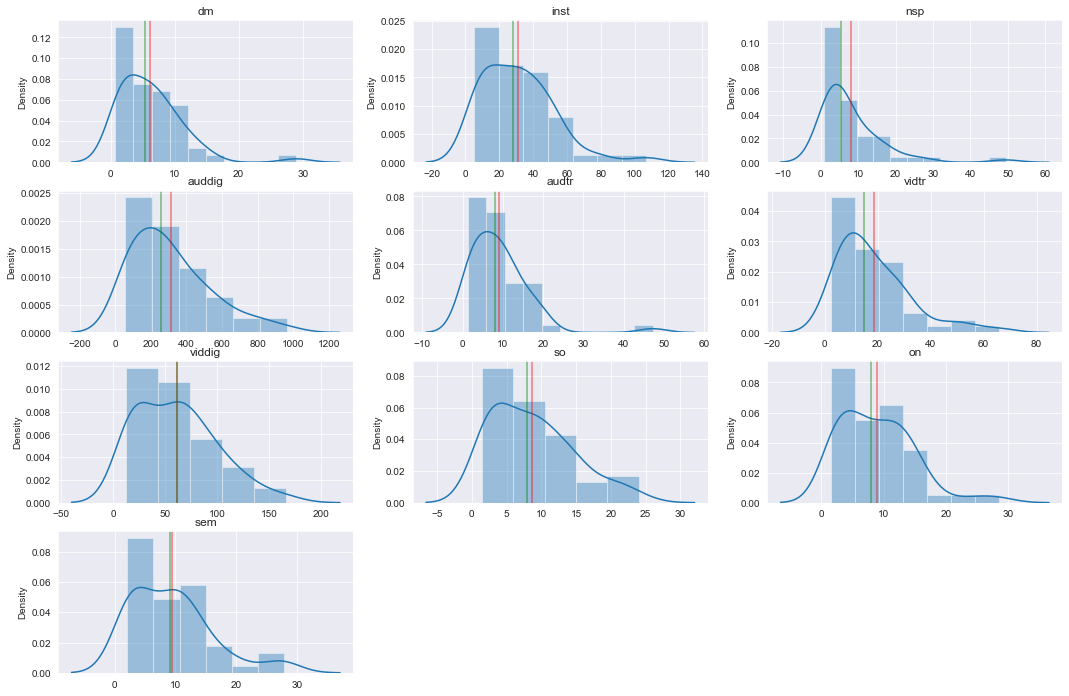

In [54]:
# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)



In [84]:
# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)

def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = hill_model['data']['X']
    if period is not None:
        cur_sp = cur_sp[-period:]
    cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    # next spending level: increase by 1%
    next_sp=list(map(lambda x: x * 1.01, cur_sp))
    # media contribution under next spending level
    next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)
    
    # mROAS
    delta_mc = next_mc - cur_mc
    delta_sp = sum(list(map(lambda x: x * mu_x, next_sp))) - sum(list(map(lambda x: x * mu_x, cur_sp)))
    mroas = delta_mc/delta_sp
    return mroas

In [99]:

# calc mROAS of recent 1 year
mroas_1y = {}

hill_model = hill_models['dm']
hill_model_params = hill_model_params_mean['dm']
cur_sp = hill_model['data']['X']

for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=30)



# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   

In [100]:
roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

roas1y_df

,roas_mean,roas_median,mroas,roas_avg
dm,6.229843,5.362814,8.917358,6.471257
inst,30.921813,28.242356,40.547312,31.526504
nsp,8.043741,5.304903,8.652167,10.669480
auddig,312.077218,260.256888,180.786159,301.710513
audtr,9.038094,8.168556,5.406888,8.768405
vidtr,18.442073,14.702937,16.009486,15.805762
viddig,61.007822,61.800738,85.390027,67.256052
so,8.726819,7.894860,4.449510,8.628629
on,8.868097,7.992374,8.615529,8.998913
sem,9.416670,9.126224,13.417133,8.984116
